# $L_{\rm X}$ - $L_{\rm R}$ diagram and relative jet faintness

This notebook can be used to reproduce the X-ray / radio luminosity diagram (Figure 3) and jet faintess versus burst fluence diagram (Figure 8) from the paper.

For the comparison with archival observations, we will apply the database maintained by Arash Bahramian and Anthony Rushton via https://github.com/bersavosh/XRB-LrLx_pub. See Reference.md for a full reference to this work and **make sure to also credit this database properly in any work deriving from this notebook**. 

Note that we have made slight adjustments to the original database plotting script to prevent it plotting the figure when loading the module and to adjust its legend.

## 0) Loading modules and plotting settings

In [2]:
import numpy as np
import lrlx_plot as lrlx
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import interpolate
from scipy import optimize
from scipy.integrate import quad
import os
from astropy.time import Time

from astropy import units as u
from astropy.units import cds
from matplotlib import colors
cds.enable()  

import matplotlib as mpl
import matplotlib.font_manager as font_manager

path = '/Library/Fonts/Arial Unicode.ttf'
prop = font_manager.FontProperties(fname=path)
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['pdf.fonttype']=42

params = {'text.usetex':False, 'mathtext.fontset':'custom', 'mathtext.default':'regular'}
mpl.rcParams.update(params)

vermillion = (0.89,0.259,0.204)
cb_blue = (0., 0.45, 0.70)

single_col = 8.9 # cm
double_col = 18.3 # cm

def cm2inch(value):
    return value/2.54

FS = 18
LS = 18
MS = 6
MEW= 1.5

# Making sure plots are shown in line:
%matplotlib inline

## 1) Reading in the data 

In [3]:
DATA = lrlx.data_reader()
DATA.head()

,Name,Class,Lr,Lr_ler,Lr_uer,Lx,Lx_ler,Lx_uer,uplim,Ref
0,A0620-00,BH,2.415711e+26,3.279963e+25,3.279963e+25,7.476976e+30,1.698887e+30,2.378977e+30,NaN,"Gallo et al. 2006, MNRAS, 370, 1351; Dincer et..."
1,A0620-00,BH,1.492718e+26,3.213025e+25,3.213025e+25,1.799294e+31,3.835548e+30,5.014996e+30,NaN,"Gallo et al. 2006, MNRAS, 370, 1351; Dincer et..."
2,XTE J1118+480,BH,1.011442e+29,0.000000e+00,0.000000e+00,2.062842e+35,0.000000e+00,0.000000e+00,NaN,"Fender et al. 2010, MNRAS, 406, 1425; Gallo et..."
3,XTE J1118+480,BH,9.855076e+28,0.000000e+00,0.000000e+00,2.097762e+35,0.000000e+00,0.000000e+00,NaN,"Fender et al. 2010, MNRAS, 406, 1425; Gallo et..."
4,XTE J1118+480,BH,7.676585e+28,0.000000e+00,0.000000e+00,1.761429e+35,0.000000e+00,0.000000e+00,NaN,"Fender et al. 2010, MNRAS, 406, 1425; Gallo et..."


In [4]:
MYDATA = DATA

In [7]:
classes = MYDATA['Class']
classes.unique()

array(['BH', 'candidateBH', 'NS', 'candidateNS', 'AMXP', 'tMSP', 'WD'],
      dtype=object)

## 2) Creating the $L_{\rm X}$-$L_{\rm R}$ diagram (Figure 3)

Defining the archival X-ray and radio data, including the detection status, for the Rapid Burster

In [9]:
Lr_arch = [1.38145539e+29, 7.09396011e+28, 7.84069276e+28, 3.36029690e+28, 3.36029690e+28]
dLr_arch = [1.68014845e+28, 1.68014845e+28, 2.61356425e+28, 1.5*1.12009897e+28, 1.5*1.12009897e+28]
Lx_arch = [5.34568575e+37, 3.13563193e+37, 6.95128041e+37, 3.96676328e+36, 6.80016562e+36]
dLx_arch = [1.24611105e+37, 7.36426197e+36, 1.62253496e+37, 2.09258088e+36, 2.74241592e+36]
Uplims = [False, False, False, True, True]

Defining the results from the 2020 campaign

In [ ]:
Lr_2020 = [2.16925833e+28]
dLr_2020 = [2.05351477e+27]
Lx_2020 = [5.97386115e+37]
dLx_2020 = [1.86683161e+37]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


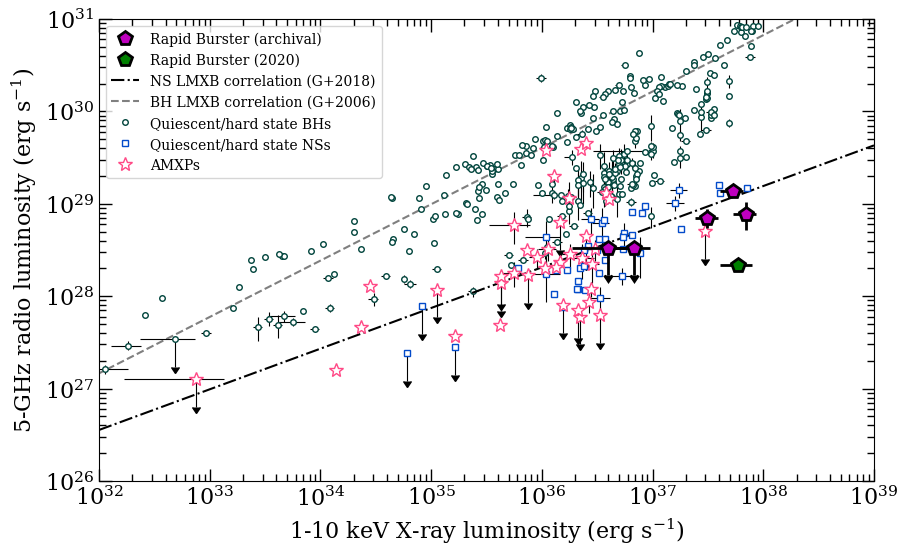

In [10]:
# Create the figure with the black holes, neutron stars, and AMXPs from the database:
FIG = plt.figure(figsize=(10,6))
FIG = lrlx.plotter(MYDATA, classes=['BH', 'NS', 'AMXP'], fig=FIG, cor_lines=True, errorbars=True, uplims=True)
AX = FIG.axes[0]

# Add the archival data for the Rapid Burster
newsrcB = AX.errorbar(Lx_arch, Lr_arch, yerr=dLr_arch, xerr=dLx_arch,
                      fmt='mp', ms=10, ecolor='k', elinewidth=2, mec='k', mew='2',
                      uplims=Uplims, zorder=10)
AX.plot([],[], 'mp', ms=10, mec='k', mew='2', label='Rapid Burster (archival)')

# Add the new, averaged data for the Rapid Burster
newsrcB = AX.errorbar(Lx_2020, Lr_2020, yerr=dLr_2020, xerr=dLx_2020,
                      fmt='gp', ms=10, ecolor='k', elinewidth=2, mec='k', mew='2', zorder=10)
AX.plot([],[], 'gp', ms=10, mec='k', mew='2', label='Rapid Burster (2020)')

# Add the model from Gallo et al. (2018)
lr0 = (10**28.57) * u.erg/u.second
lx0 = (10**36.2) * u.erg/u.second
beta = 0.44
alpha = -0.17

line_x = np.logspace(32,39)
line_y = (10**alpha)*(lr0.value)*((line_x/lx0.value)**beta)
newline, = AX.plot(line_x,line_y,'-.k',label='NS LMXB correlation (G+2018)')

# Add the legend for the plotting correlation from Gallo et al. (2006)
AX.plot([],[],'--',color='0.50',label='BH LMXB correlation (G+2006)')

# Set the axis limits
AX.set_xlim(1e32,1e39)
AX.set_ylim(1e26,1e31)

# Define the colors and use those to add legend labels for the BHs, NSs, and AMXPs:
colorset = ['#000000', '#00270C', '#00443C', '#005083', '#034BCA', '#483CFC', '#9C2BFF', '#EB24F4', 
            '#FF2DC2', '#FF4986', '#FF7356', '#FFA443', '#EBD155', '#D3F187', '#D7FFC8', '#FFFFFF']

AX.loglog([],[],'o',ms=4, mec=colorset[2],c='w',zorder=2,mew=1, label='Quiescent/hard state BHs')
AX.loglog([],[],'s',ms=5, mec=colorset[4],c='w',mew=1,zorder=3, label='Quiescent/hard state NSs')
AX.loglog([],[],'*',ms=10, mec=colorset[9],c='w',mew=1,zorder=5, label='AMXPs')

AX.legend()

FIG;

# Save
FIG.savefig('Figure3.pdf',dpi=300, bbox_inches='tight')

## 3) Create the comparison of relative jet brightness

First, we define the maximum radio luminosity reaches by the Rapid Burster on a scan-by-scan time scale:

In [13]:
# The maximum value during the 2020 campaign:
Lr_2020max = 3.59850461e+28
dLr_2020max = 6.16054431e+27

Secondly, we scale all values, both archival and 2020, to the Gallo et al. (2018) relation ($\log L_{\rm R,0} = 28.57$, $\log L_{\rm X,0} = 36.20$, and $\beta=0.44$), as defined in the main paper:

$\alpha = \log \left(\frac{\overline{L_{\rm R}}}{\overline{L_{\rm X}}^{\beta}}\right)$,

where $\overline{L_{\rm i}} = L_{\rm i}/ L_{\rm i,0}$. The full NS LMXB sample has $\alpha = -0.17$ as its best-fit value; here, we calculate this value for each observation.

In [15]:
# Defining the model fit
lr0 = (10**28.57) * u.erg/u.second
lx0 = (10**36.2) * u.erg/u.second
beta = 0.44

# Scaling the luminosities for archival, 2020, and 2020 maximum data:
lr_arch = np.asarray(Lr_arch) / lr0.value
dlr_arch = np.asarray(dLr_arch) / lr0.value
lx_arch = np.asarray(Lx_arch) / lx0.value
dlx_arch = np.asarray(dLx_arch) / lx0.value

lr_2020 = np.asarray(Lr_2020) / lr0.value
dlr_2020 = np.asarray(dLr_2020) / lr0.value
lx_2020 = np.asarray(Lx_2020) / lx0.value
dlx_2020 = np.asarray(dLx_2020) / lx0.value

lr_2020max = np.asarray(Lr_2020max) / lr0.value
dlr_2020max = np.asarray(dLr_2020max) / lr0.value

# Calculating the ratio, with the correction for the slope beta, and its error (from error propegation)
RATIO_beta_arch = lr_arch / (lx_arch**beta)
dRATIO_beta_arch = RATIO_beta_arch * np.sqrt((dlr_arch/lr_arch)**2 + ((dlx_arch/(lx_arch**beta))**2)*((beta*(lx_arch**(beta-1.)))**2.))
dRATIO_beta_arch = np.concatenate([dRATIO_beta_arch[0:3], dRATIO_beta_arch[3:]/2.])
                                             
RATIO_beta_2020 = lr_2020 / (lx_2020**beta)
dRATIO_beta_2020 = RATIO_beta_2020 * np.sqrt((dlr_2020/lr_2020)**2 + ((dlx_2020/(lx_2020**beta))**2)*((beta*(lx_2020**(beta-1.)))**2.))

RATIO_beta_2020max = lr_2020max / (lx_2020**beta)
dRATIO_beta_2020max = RATIO_beta_2020max * np.sqrt((dlr_2020max/lr_2020max)**2 + ((dlx_2020/(lx_2020**beta))**2)*((beta*(lx_2020**(beta-1.)))**2.))

Thirdly, we define the burst fluences. See the main paper and the Lightcurves.ipynb for their calculation.

In [16]:
burst_fluence_arch = [0.0, 0.0, 0.0, 78., 100.]
burst_fluence_2020 = [86.]

Then, we have to repeat this calculation for the archival dataset of NS LMXBs:

In [17]:
# Reading in the data
NS_DATA = DATA[DATA['Class'] == 'NS']
AMXP_DATA = DATA[DATA['Class'] == 'AMXP']

# Selecting sources / observations with a detection
NS_DET = NS_DATA[NS_DATA['uplim'] != 'Lr']
AMXP_DET = AMXP_DATA[AMXP_DATA['uplim'] != 'Lr']

# Turning the detections into arrays; calculating the average uncertainty for the few observations
# with asymmetric errors:
NS_Lx = np.asarray(NS_DET['Lx'])
NS_dLx = (np.asarray(NS_DET['Lx_ler']) + np.asarray(NS_DET['Lx_uer']))/2.
NS_Lr = np.asarray(NS_DET['Lr'])
NS_dLr = (np.asarray(NS_DET['Lr_ler']) + np.asarray(NS_DET['Lr_uer']))/2.

# For observations without an uncertainty, assumed a 10% uncertainty. 
for i in range(len(NS_dLx)):
    if NS_dLx[i] == 0.:
        NS_dLx[i] = 0.1*NS_Lx[i]
    if NS_dLr[i] == 0.:
        NS_dLr[i] = 0.1*NS_Lr[i]

# Repeat the above steps for the AMXPs:
AMXP_Lx = np.asarray(AMXP_DET['Lx'])
AMXP_dLx = (np.asarray(AMXP_DET['Lx_ler']) + np.asarray(AMXP_DET['Lx_uer']))/2.
AMXP_Lr = np.asarray(AMXP_DET['Lr']) 
AMXP_dLr = (np.asarray(AMXP_DET['Lr_ler']) + np.asarray(AMXP_DET['Lr_uer']))/2.

for i in range(len(AMXP_dLx)):
    if AMXP_dLx[i] == 0.:
        AMXP_dLx[i] = 0.1*AMXP_Lx[i]
    if AMXP_dLr[i] == 0.:
        AMXP_dLr[i] = 0.1*AMXP_Lr[i]

# Combined the NS and AMXP classes and scaling to the reference luminosity:
lx_Both = np.concatenate([NS_Lx, AMXP_Lx]) / lx0.value
dlx_Both = np.concatenate([NS_dLx, AMXP_dLx]) / lx0.value
lr_Both = np.concatenate([NS_Lr, AMXP_Lr]) / lr0.value
dlr_Both = np.concatenate([NS_dLr, AMXP_dLr]) / lr0.value

# Calculating the ratio alpha taking the slope beta into account. 
RATIO_beta_Both = lr_Both / (lx_Both**beta)
dRATIO_beta_Both = RATIO_beta_Both * np.sqrt((dlr_Both/lr_Both)**2 + ((dlx_Both/(lx_Both**beta))**2)*((beta*(lx_Both**(beta-1.)))**2.))

# Recalculating 1e5 iterations of the RATIO array, where for each, we vary the scaled luminosities within
# their errors, in order to assess the affect that the uncertainties have on the distribution.
Nsim = 10000

SIM_RATIO = RATIO_beta_Both
for i in range(len(lx_Both)):
    lx_Both_sim = np.random.normal(lx_Both[i], dlx_Both[i], size=Nsim)
    lr_Both_sim = np.random.normal(lr_Both[i], dlr_Both[i], size=Nsim)
    
    SIM_RATIO = np.concatenate([SIM_RATIO, lr_Both_sim / (lx_Both_sim**beta)])

/var/folders/3t/y6zmbx750n58jg6y8006hwqc0000gq/T/ipykernel_88407/1448962402.py:54: RuntimeWarning: invalid value encountered in power
  SIM_RATIO = np.concatenate([SIM_RATIO, lr_Both_sim / (lx_Both_sim**beta)])


Finally, we can turn to creating the plot for Figure 8:

/var/folders/3t/y6zmbx750n58jg6y8006hwqc0000gq/T/ipykernel_88407/2354175181.py:82: RuntimeWarning: invalid value encountered in log10
  ax2.hist(np.log10(SIM_RATIO), density=True, color='k', histtype='step', lw=2, zorder=6,


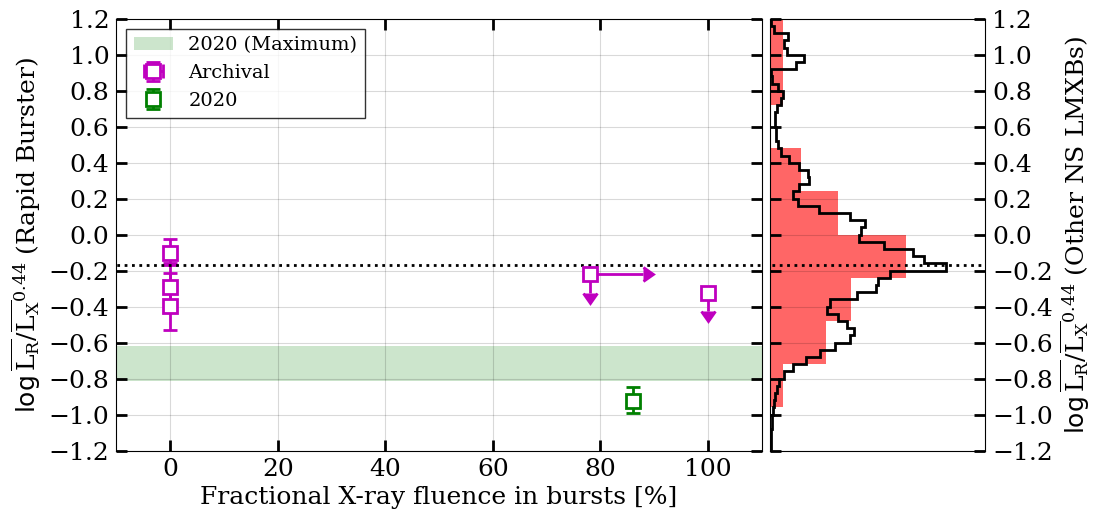

In [18]:
# Define the figure with unequal subplot sizes and a small space separating them:
fig, (ax, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(cm2inch(3.2*single_col),cm2inch(1.6*single_col)))
plt.subplots_adjust(wspace=0.02)# hspace=0)

##### LEFT-HAND PANEL #####

# Label the left X-axis and set the tick properties:
ax.set_xlabel('Fractional X-ray fluence in bursts [%]', fontsize=FS)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

# Calculate the log versions of the archival data
RATIO_beta_arch_log_error_p = np.log10(RATIO_beta_arch+dRATIO_beta_arch)-np.log10(RATIO_beta_arch) 
RATIO_beta_arch_log_error_m = np.log10(RATIO_beta_arch)-np.log10(RATIO_beta_arch-dRATIO_beta_arch)

# Plotting the arhival data; note that we assign a large uncertainty to point 4 so that its lower x limit it clear.
ax.errorbar(burst_fluence_arch, np.log10(RATIO_beta_arch), yerr=[RATIO_beta_arch_log_error_p, RATIO_beta_arch_log_error_m], 
            fmt='ws', ms=10, mec='m', elinewidth=2, ecolor='m', uplims=Uplims, capsize=5, markeredgewidth=2,
            xlolims=[False, False, False, True, False], xerr=[0., 0., 0., 10., 0.],
            label='Archival')

# Repeat the above calculation and plotting for the 2020 campaign:
RATIO_beta_2020_log_error_p = np.log10(RATIO_beta_2020+dRATIO_beta_2020)-np.log10(RATIO_beta_2020) 
RATIO_beta_2020_log_error_m = np.log10(RATIO_beta_2020)-np.log10(RATIO_beta_2020-dRATIO_beta_2020)

ax.errorbar(burst_fluence_2020, np.log10(RATIO_beta_2020), yerr=[RATIO_beta_2020_log_error_p, RATIO_beta_2020_log_error_m],
            fmt='ws', ms=10, elinewidth=2, mec='g', ecolor='g', capsize=5, markeredgewidth=2, label='2020')

# Repeat the above calculation and plotting for the maximum of the 2020 campaign:
RATIO_beta_2020max_log_error_p = np.log10(RATIO_beta_2020max+dRATIO_beta_2020max) 
RATIO_beta_2020max_log_error_m = np.log10(RATIO_beta_2020max-dRATIO_beta_2020max)

ax.fill_between([-100,200], [RATIO_beta_2020max_log_error_p[0], RATIO_beta_2020max_log_error_p[0]],
                [RATIO_beta_2020max_log_error_m[0], RATIO_beta_2020max_log_error_m[0]], facecolor='g', alpha=0.2,
                label='2020 (Maximum)')

# Plot the best-fit alpha from Gallo et al. (2020):
ax.plot([-100,200], [-0.17, -0.17], 'k:', lw=2)

# Set the X and Y limits, and add a grid:
ax.set_ylim(-1.2, 1.2)
ax.set_xlim(-10, 110)
ax.grid(zorder=-10, color='k', alpha=0.15)

# Add the y-labels and ticks
ax.set_ylabel('$\log \overline{L_R}/\overline{L_X}^{0.44}$ (Rapid Burster)', fontsize=FS)
ax.set_yticks(np.linspace(-1.2, 1.2, 13, endpoint=True))

# Add the legend
leg = ax.legend(loc=2, fontsize=FS-4, frameon=True, fancybox=False)
leg.get_frame().set_edgecolor('k')

##### RIGHT-HAND PANEL #####

# Place the ticks on the right and set the general tick / label properties:
ax2.yaxis.tick_right()
ax2.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.get_yaxis().set_tick_params(direction='in', which='both')
ax2.get_xaxis().set_tick_params(direction='in', which='both')

ax2.set_yticks(np.linspace(-1.2, 1.2, 13, endpoint=True))
ax2.set_ylim(-1.2, 1.2)

# Remove the X-ticks
ax2.set_xticks([])

# Set the Y label and place it right
ax2.set_ylabel('$\log \overline{L_R}/\overline{L_X}^{0.44}$ (Other NS LMXBs)', fontsize=FS)
ax2.yaxis.set_label_position("right")

# Set the X limits and define a grid
ax2.set_xlim(0,2.2)
ax2.grid(zorder=-10, color='k', alpha=0.15)

# Plot the histogram of the MC-varied and observed ratios of the sample of NS LMXBs; rotated by 90%:
ax2.hist(np.log10(SIM_RATIO), density=True, color='k', histtype='step', lw=2, zorder=6,
        bins=np.linspace(-1.2, 1.2, 60+1, endpoint=True), orientation='horizontal')

ax2.hist(np.log10(RATIO_beta_Both), density=True, color='r', alpha=0.6, histtype='bar', lw=2, zorder=1,
        bins=np.linspace(-1.2, 1.2, 10+1, endpoint=True), orientation='horizontal')  # density=False would make counts

# Plot the best-fit alpha from Gallo et al. (2020):
ax2.plot([-100,200], [-0.17, -0.17], 'k:', lw=2)

# Save the Figure
plt.savefig('Figure8.pdf', bbox_inches='tight')